## Enabling Import of Custom Python Modules from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S11')

In [0]:
from torch.utils.data import DataLoader, Dataset

In [4]:
from albumentations import *
from albumentations.pytorch import ToTensor
import data_preprocess_Albumentation_module_1
import resnet_modified
import train_test_module_CrossEntropy
import gradcam_module
import lr_finder_module
import misclassified_module
import cyclicLR_module

  pip install torch-lr-finder -v --global-option="amp"


CUDA Available? True


In [0]:
from __future__ import print_function
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

### Using GPU instead of CPU

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [7]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_preprocess_Albumentation_module_1.albumentation_train())

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_preprocess_Albumentation_module_1.albumentation_test())

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



In [0]:
trainloader, testloader = data_preprocess_Albumentation_module_1.get_train_test_loader(trainset, testset)

plane   dog  deer  deer


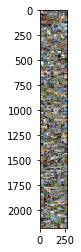

In [9]:
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
images.shape

torch.Size([512, 3, 32, 32])

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [11]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = resnet_modified.resnet_mod().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         Dropout2d-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
         Dropout2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
        Dropout2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
       BasicBlock-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

## Cyclic LR

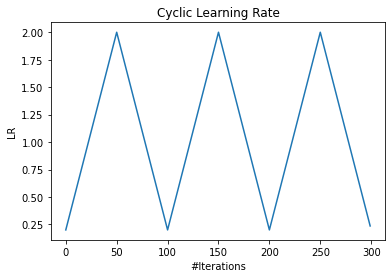

In [12]:
cyclicLR_plot = cyclicLR_module.LRCyclePlot({})
cyclicLR_plot()

## LR Finder


Learning rate search finished. See the graph with {finder_name}.plot()


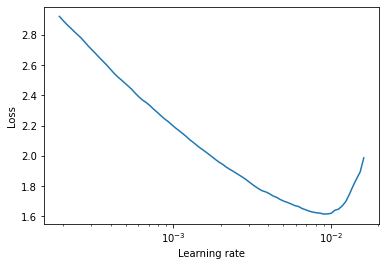

In [13]:
from torch.optim.lr_scheduler import StepLR

net =  resnet_modified.resnet_mod().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0005)
lr_finder = lr_finder_module.LRFinder(net, optimizer, criterion)
lr_finder.range_test(trainloader, start_lr=1e-4, end_lr=0.02, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state


In [14]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))

Best Loss: 1.615285916932292
Best Learning Rate: 0.009033904523224428


In [21]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

net =  resnet_modified.resnet_mod().to(device)
optimizer = optim.SGD(net.parameters(), lr=best_lr, momentum=0.9, weight_decay=0.0005)
scheduler = OneCycleLR(optimizer, max_lr=best_lr, steps_per_epoch=len(trainloader),
                       epochs=24, div_factor=10, final_div_factor=1,
                       pct_start=5/24, anneal_strategy="linear")

EPOCHS = 24
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)   
    train_test_module_CrossEntropy.train(net, device, trainloader, optimizer, epoch)
    train_test_module_CrossEntropy.test(net, device, testloader)
    scheduler.step()

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.8434363603591919 Batch_id=97 Accuracy=67.26: 100%|██████████| 98/98 [00:17<00:00,  5.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -4.3904, Accuracy: 6966/10000 (69.66%)

EPOCH: 3


Loss=0.7900561094284058 Batch_id=97 Accuracy=71.98: 100%|██████████| 98/98 [00:17<00:00,  5.47it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -4.9038, Accuracy: 7265/10000 (72.65%)

EPOCH: 4


Loss=0.7445535063743591 Batch_id=97 Accuracy=75.11: 100%|██████████| 98/98 [00:17<00:00,  5.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -5.3783, Accuracy: 7677/10000 (76.77%)

EPOCH: 5


Loss=0.6177433133125305 Batch_id=97 Accuracy=78.23: 100%|██████████| 98/98 [00:17<00:00,  5.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -5.7946, Accuracy: 7921/10000 (79.21%)

EPOCH: 6


Loss=0.6235686540603638 Batch_id=97 Accuracy=79.28: 100%|██████████| 98/98 [00:17<00:00,  5.59it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -6.4901, Accuracy: 7953/10000 (79.53%)

EPOCH: 7


Loss=0.4307774603366852 Batch_id=97 Accuracy=81.13: 100%|██████████| 98/98 [00:17<00:00,  5.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -6.5901, Accuracy: 8168/10000 (81.68%)

EPOCH: 8


Loss=0.5060185194015503 Batch_id=97 Accuracy=83.24: 100%|██████████| 98/98 [00:17<00:00,  5.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -7.0488, Accuracy: 8135/10000 (81.35%)

EPOCH: 9


Loss=0.45530927181243896 Batch_id=97 Accuracy=84.24: 100%|██████████| 98/98 [00:17<00:00,  5.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -7.1964, Accuracy: 8090/10000 (80.90%)

EPOCH: 10


Loss=0.45148295164108276 Batch_id=97 Accuracy=85.46: 100%|██████████| 98/98 [00:17<00:00,  5.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -7.9815, Accuracy: 8292/10000 (82.92%)

EPOCH: 11


Loss=0.4184582233428955 Batch_id=97 Accuracy=85.76: 100%|██████████| 98/98 [00:17<00:00,  5.65it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -8.2803, Accuracy: 8217/10000 (82.17%)

EPOCH: 12


Loss=0.34328725934028625 Batch_id=97 Accuracy=86.91: 100%|██████████| 98/98 [00:17<00:00,  5.67it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -8.0429, Accuracy: 8415/10000 (84.15%)

EPOCH: 13


Loss=0.3875996768474579 Batch_id=97 Accuracy=88.10: 100%|██████████| 98/98 [00:17<00:00,  5.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -8.5932, Accuracy: 8379/10000 (83.79%)

EPOCH: 14


Loss=0.39592432975769043 Batch_id=97 Accuracy=88.55: 100%|██████████| 98/98 [00:17<00:00,  5.66it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -8.3979, Accuracy: 8272/10000 (82.72%)

EPOCH: 15


Loss=0.3324281573295593 Batch_id=97 Accuracy=89.13: 100%|██████████| 98/98 [00:17<00:00,  5.59it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -9.0139, Accuracy: 8598/10000 (85.98%)

EPOCH: 16


Loss=0.22619940340518951 Batch_id=97 Accuracy=89.91: 100%|██████████| 98/98 [00:17<00:00,  5.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -9.5638, Accuracy: 8581/10000 (85.81%)

EPOCH: 17


Loss=0.25424379110336304 Batch_id=97 Accuracy=90.13: 100%|██████████| 98/98 [00:17<00:00,  5.59it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -9.5529, Accuracy: 8622/10000 (86.22%)

EPOCH: 18


Loss=0.28149160742759705 Batch_id=97 Accuracy=90.58: 100%|██████████| 98/98 [00:17<00:00,  5.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -9.3591, Accuracy: 8372/10000 (83.72%)

EPOCH: 19


Loss=0.2935808002948761 Batch_id=97 Accuracy=91.07: 100%|██████████| 98/98 [00:17<00:00,  5.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -9.5270, Accuracy: 8658/10000 (86.58%)

EPOCH: 20


Loss=0.2506864070892334 Batch_id=97 Accuracy=91.82: 100%|██████████| 98/98 [00:17<00:00,  5.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -9.9712, Accuracy: 8614/10000 (86.14%)

EPOCH: 21


Loss=0.3095652163028717 Batch_id=97 Accuracy=92.24: 100%|██████████| 98/98 [00:17<00:00,  5.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -10.4978, Accuracy: 8721/10000 (87.21%)

EPOCH: 22


Loss=0.1901470571756363 Batch_id=97 Accuracy=92.19: 100%|██████████| 98/98 [00:17<00:00,  5.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -10.2802, Accuracy: 8743/10000 (87.43%)

EPOCH: 23


Loss=0.2398425042629242 Batch_id=97 Accuracy=92.96: 100%|██████████| 98/98 [00:17<00:00,  5.65it/s]



Test set: Average loss: -11.0677, Accuracy: 8719/10000 (87.19%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


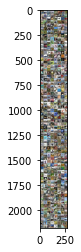

In [24]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images.cuda())

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [26]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data, target in testloader:
        images, labels = data.to(device), target.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 87 %


In [28]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data, target in testloader:
        images, labels = data.to(device), target.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 85 %
Accuracy of   car : 100 %
Accuracy of  bird : 85 %
Accuracy of   cat : 41 %
Accuracy of  deer : 85 %
Accuracy of   dog : 66 %
Accuracy of  frog : 81 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %


## Misclasified Images & GradCam 

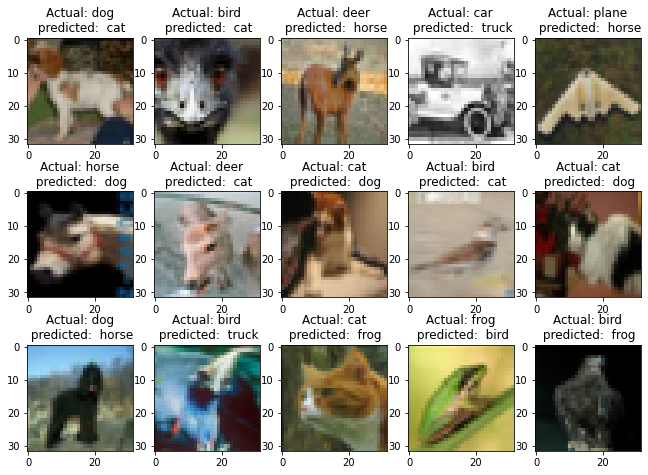

<Figure size 432x288 with 0 Axes>

In [29]:
images, actuals, preds = misclassified_module.test_misclassified(net,device,testloader)
misclassified_module.plot_images(images, actuals, preds, classes)
from google.colab import files
plt.savefig("Misclassified Images.png")
files.download("Misclassified Images.png")

In [0]:
target_layers = ["layer1", "layer3"]
viz_cam = gradcam_module.VisualizeCam(net,classes, target_layers)

In [0]:
temp = [i.item() for i in actuals]
images_x = torch.Tensor(images) # transform to torch tensor
actuals_y = torch.Tensor(temp)
misclasified_dataset = TensorDataset(images_x,actuals_y) # create your datset
misclasified_dataloader = DataLoader(misclasified_dataset)

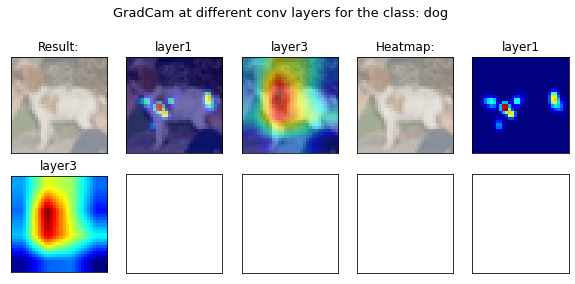

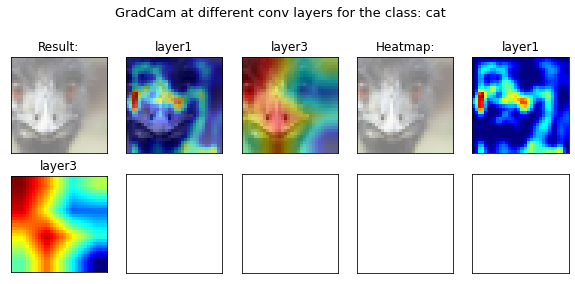

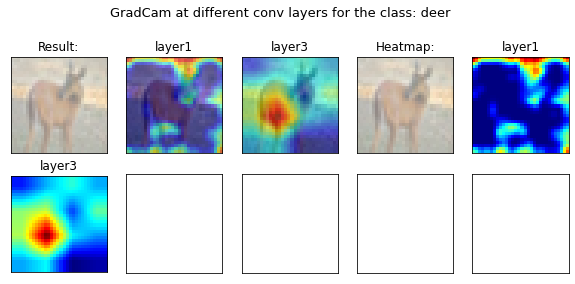

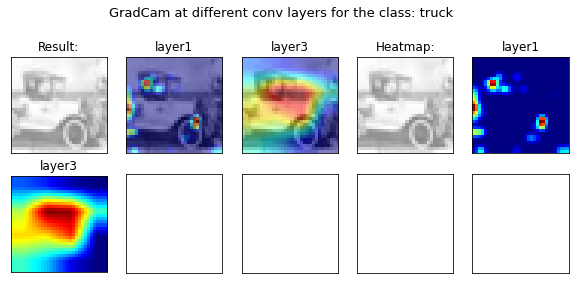

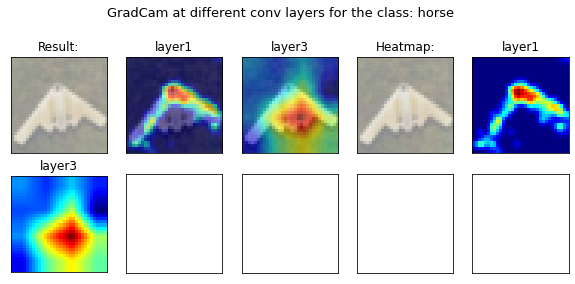

In [38]:
dataiter = iter(misclasified_dataloader)
for i in range(5):
  img, label = dataiter.next()
  viz_cam(img, target_layers)

